In [4]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

from ssm.models import SLDS
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
from ssm.util import random_rotation, find_permutation

import h5py

In [63]:
###ICA signal
f = h5py.File('/home/kschen/github/local-linear-segmentation/AML32_moving.hdf5','r')  #GCamp6s
#f = h5py.File('/home/kschen/github/local-linear-segmentation/AML18_moving.hdf5','r')  #GFP
#f = h5py.File('/home/kschen/github/local-linear-segmentation/AML32_immobilized.hdf5','r')  #GCamp6s immobalized

In [64]:
###neural
#neu = np.array(f['BrainScanner20171017_170419']['Neurons']['Activity'])  #immobalized
neu = np.array(f['BrainScanner20170424_105620']['Neurons']['Activity'])  #moving
neu = neu[:,500:]  #remove initial
#plt.imshow(neu[:,1000:2000],aspect="auto")

In [65]:
###behavioral
beh = np.array(f['BrainScanner20170424_105620']['Behavior']['Ethogram'])  #moving
beh = beh[500:]  #remove initial
#plt.imshow(beh[1000:2000][None,:],aspect="auto")
ethos = len(np.unique(beh))

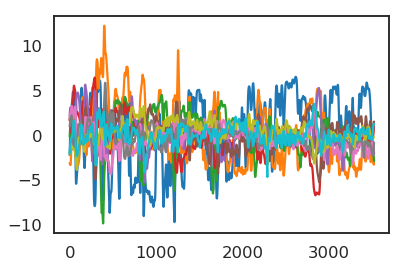

In [86]:
dims = 10
C = np.cov(neu)
u,s,v = np.linalg.svd(C)
eV = u[:,:dims]
PCs = (eV.T @ neu).T
plt.plot(PCs)

In [87]:
###Set the parameters of the SLDS
T = PCs.shape[0]    # number of time bins
K = ethos       # number of discrete states
D = 2       # number of latent dimensions
N = PCs.shape[1]      # number of observed dimensions

In [88]:
# Make an SLDS with the true parameters
true_slds = SLDS(N, K, D, emissions="gaussian")
for k in range(K):
    true_slds.dynamics.As[k] = .95 * random_rotation(D, theta=(k+1) * np.pi/20)
z, x, y = true_slds.sample(T)

# Mask off some data
mask = npr.rand(T, N) < 0.9
y_masked = y * mask
PC_masked = PCs*mask

In [96]:
###fitting variational posteriors

print("Fitting SLDS with SVI")

# Create the model and initialize its parameters
slds = SLDS(N, K, D, emissions="gaussian")
slds.initialize(PC_masked,masks=mask)

# Create a variational posterior
q_mf = SLDSMeanFieldVariationalPosterior(slds, PC_masked, masks=mask)
q_mf_elbos = slds.fit(q_mf, PC_masked, masks=mask, num_iters=2000, initialize=False)

# Get the posterior mean of the continuous states
q_mf_x = q_mf.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(q_mf_x, PCs)))
q_mf_z = slds.most_likely_states(q_mf_x, PCs)

# Smooth the data under the variational posterior
q_mf_y = slds.smooth(q_mf_x, PCs)

Fitting SLDS with SVI
Initializing with an ARHMM using 25 steps of EM.


/home/kschen/.local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


In [89]:
print("Fitting SLDS with SVI using structured variational posterior")
slds = SLDS(N, K, D, emissions="gaussian")
slds.initialize(PC_masked,masks=mask)

q_struct = SLDSTriDiagVariationalPosterior(slds, PC_masked,masks=mask)
q_struct_elbos = slds.fit(q_struct, PC_masked, masks=mask, num_iters=2000, initialize=False)

# Get the posterior mean of the continuous states
q_struct_x = q_struct.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(q_struct_x, PCs)))
q_struct_z = slds.most_likely_states(q_struct_x, PCs)

# Smooth the data under the variational posterior
q_struct_y = slds.smooth(q_struct_x, PCs)

Fitting SLDS with SVI using structured variational posterior
Initializing with an ARHMM using 25 steps of EM.


/home/kschen/.local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


In [4]:
# print("Fitting SLDS with SVI")

# # Create the model and initialize its parameters
# slds = SLDS(N, K, D, emissions="gaussian")
# slds.initialize(y_masked, masks=mask)

# # Create a variational posterior
# q_mf = SLDSMeanFieldVariationalPosterior(slds, y_masked, masks=mask)
# q_mf_elbos = slds.fit(q_mf, y_masked, masks=mask, num_iters=1000, initialize=False)

# # Get the posterior mean of the continuous states
# q_mf_x = q_mf.mean[0]

# # Find the permutation that matches the true and inferred states
# slds.permute(find_permutation(z, slds.most_likely_states(q_mf_x, y)))
# q_mf_z = slds.most_likely_states(q_mf_x, y)

# # Smooth the data under the variational posterior
# q_mf_y = slds.smooth(q_mf_x, y)

Fitting SLDS with SVI
Initializing with an ARHMM using 25 steps of EM.


In [5]:
# print("Fitting SLDS with SVI using structured variational posterior")
# slds = SLDS(N, K, D, emissions="gaussian")
# slds.initialize(y_masked, masks=mask)

# q_struct = SLDSTriDiagVariationalPosterior(slds, y_masked, masks=mask)
# q_struct_elbos = slds.fit(q_struct, y_masked, masks=mask, num_iters=1000, initialize=False)

# # Get the posterior mean of the continuous states
# q_struct_x = q_struct.mean[0]

# # Find the permutation that matches the true and inferred states
# slds.permute(find_permutation(z, slds.most_likely_states(q_struct_x, y)))
# q_struct_z = slds.most_likely_states(q_struct_x, y)

# # Smooth the data under the variational posterior
# q_struct_y = slds.smooth(q_struct_x, y)

Fitting SLDS with SVI using structured variational posterior
Initializing with an ARHMM using 25 steps of EM.


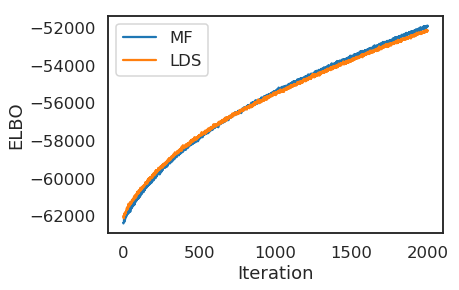

In [97]:
# Plot the ELBOs
plt.plot(q_mf_elbos, label="MF")
plt.plot(q_struct_elbos, label="LDS")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

(0, 3526)

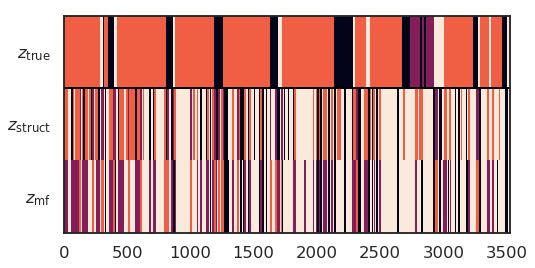

In [101]:
# Plot the true and inferred states
xlim = (0, T)

plt.figure(figsize=(8,4))
plt.imshow(np.row_stack((beh+1, q_struct_z, q_mf_z)), aspect="auto")
plt.plot(xlim, [0.5, 0.5], '-k', lw=2)
plt.yticks([0, 1, 2], ["$z_{\\mathrm{true}}$", "$z_{\\mathrm{struct}}$", "$z_{\\mathrm{mf}}$"])
plt.xlim(xlim)

Text(0, 0.5, 'x2')

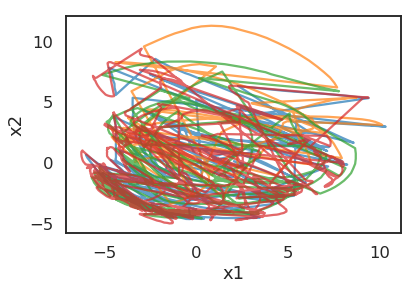

In [92]:
for dd in range(K):
    pos = np.where(q_struct_z==dd)[0]
    plt.plot(q_struct_x[pos,0],q_struct_x[pos,1],alpha=0.7)
plt.xlabel('x1')
plt.ylabel('x2')

In [74]:
x.shape

(3526, 2)

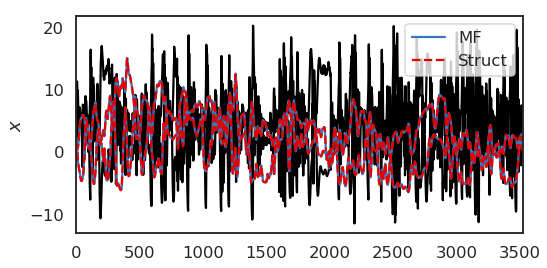

In [40]:
plt.figure(figsize=(8,4))
plt.plot(x + 4 * np.arange(D), '-k')
for d in range(D):
    plt.plot(q_mf_x[:,d] + 4 * d, '-', color=colors[0], label="MF" if d==0 else None)
    plt.plot(q_struct_x[:,d] + 4 * d, '--', color=colors[1], label="Struct" if d==0 else None)
plt.ylabel("$x$")
plt.xlim(xlim)
plt.legend()

(0, 3526)

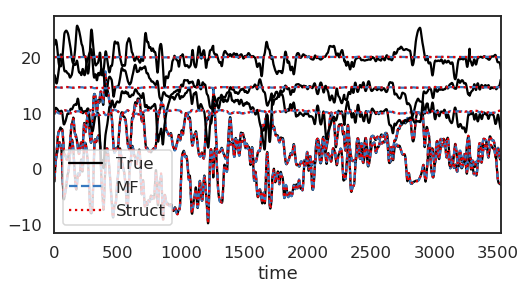

In [79]:
# Plot the smoothed observations
plt.figure(figsize=(8,4))
for n in range(N):
    plt.plot(PCs[:, n] + 5 * n, '-k', label="True" if n == 0 else None)
    plt.plot(q_mf_y[:, n] + 5 * n, '--', color=colors[0], label="MF" if n == 0 else None)
    plt.plot(q_struct_y[:, n] + 5 * n, ':',  color=colors[1], label="Struct" if n == 0 else None)
plt.legend()
plt.xlabel("time")
plt.xlim(xlim)

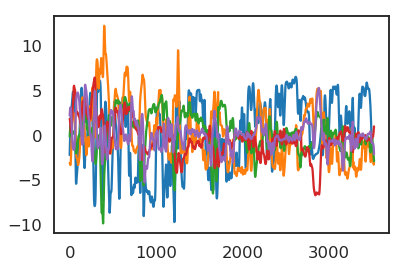

In [78]:
plt.plot(PCs)